<a href="https://colab.research.google.com/github/cxbxmxcx/DeepLearningBeginnings/blob/master/DeepLearningTensorFlow_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub generative image model

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>


This Colab demonstrates use of a TF-Hub module based on a generative adversarial network (GAN). The module maps from N-dimensional vectors, called latent space, to RGB images.

Two examples are provided:
* **Mapping** from latent space to images, and
* Given a target image, **using gradient descent to find** a latent vector that generates an image similar to the target image.

## Optional prerequisites

* Familiarity with [low level Tensorflow concepts](https://www.tensorflow.org/guide/low_level_intro).
* [Generative Adversarial Network](https://en.wikipedia.org/wiki/Generative_adversarial_network) on Wikipedia.
* Paper on Progressive GANs: [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196).

In [0]:
# Install the latest Tensorflow version.
!pip -q install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip -q install tensorflow-hub
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image

In [0]:
#@title Imports and function definitions

from absl import logging

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)


# Given a set of images, show an animation.
def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))


# Simple way to display an image.
def display_image(image):
  plt.figure()
  plt.axis("off")
  plt.imshow(image)


# Display multiple images in the same figure.
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()

logging.set_verbosity(logging.ERROR)

## Latent space interpolation

### Random vectors

Latent space interpolation between two randomly initialized vectors. We will use a TF-Hub module [progan-128](https://tfhub.dev/google/progan-128/1) that contains a pre-trained Progressive GAN.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


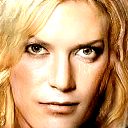

In [0]:
def interpolate_between_vectors():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    # Change the seed to get different random vectors.
    v1 = tf.random_normal([latent_dim], seed=3)
    v2 = tf.random_normal([latent_dim], seed=1)
    
    # Creates a tensor with 50 steps of interpolation between v1 and v2.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # Uses module to generate images from the latent space.
    interpolated_images = module(vectors)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      interpolated_images_out = session.run(interpolated_images)

    animate(interpolated_images_out)

interpolate_between_vectors()

## Finding closest vector in latent space
Fix a target image. As an example use an image generated from the module or upload your own.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


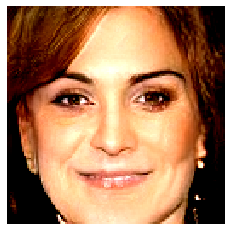

In [0]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    vector = tf.random_normal([1, latent_dim], seed=4)
    images = module(vector)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      image_out = session.run(images)[0]
  return image_out

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()
display_image(target_image)

After defining a loss function between the target image and the image generated by a latent space variable, we can use gradient descent to find variable values that minimize the loss.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0.688769
5.607328
5.049135
2.725675
0.73154974
1.4969605
0.82845354
1.147059
1.4738402
0.78106093
0.8780064
1.2609408
0.8296215
0.5127669
0.7657167
0.28119412
1.0127039
1.3107775
0.957603
0.17578664
0.38918257
0.22698265
0.20097658
0.37962362
0.1464316
0.8295889
0.9538052
0.50049645
0.64079463
0.9423418
0.6885255
0.25500512
0.40413067
0.17227611
0.18611047
0.35647076
0.16538653
0.6988709
0.7978394
0.37108275


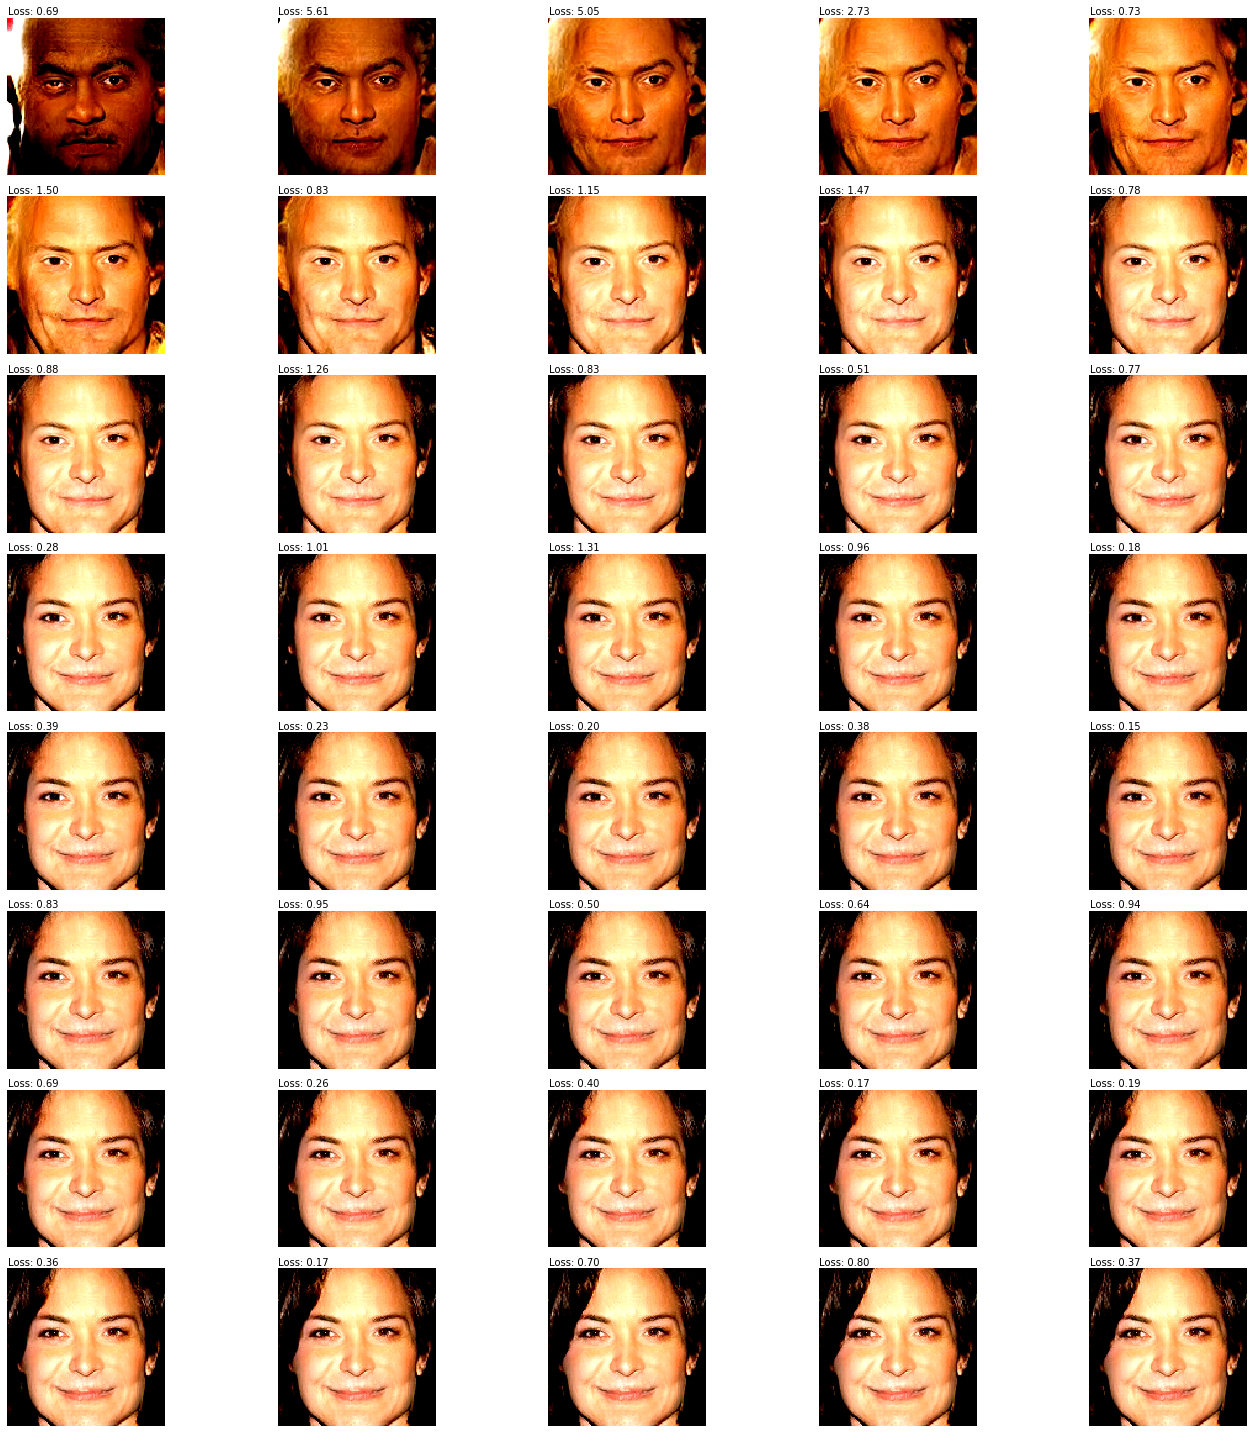

In [0]:
def find_closest_latent_vector(num_optimization_steps):
  images = []
  losses = []
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    initial_vector = tf.random_normal([1, latent_dim], seed=5)

    vector = tf.get_variable("vector", initializer=initial_vector)
    image = module(vector)

    target_image_difference = tf.reduce_sum(
        tf.losses.absolute_difference(image[0], target_image[:,:,:3]))

    # The latent vectors were sampled from a normal distribution. We can get
    # more realistic images if we regularize the length of the latent vector to 
    # the average length of vector from this distribution.
    regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
    
    loss = target_image_difference + regularizer
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
    train = optimizer.minimize(loss)

    with tf.Session() as session:
      session.run(tf.global_variables_initializer())
      for _ in range(num_optimization_steps):
        _, loss_out, im_out = session.run([train, loss, image])
        images.append(im_out[0])
        losses.append(loss_out)
        print(loss_out)
    return images, losses


result = find_closest_latent_vector(num_optimization_steps=40)
display_images(result[0], [("Loss: %.2f" % loss) for loss in result[1]])

### Playing with the above example
If image is from the module space, the descent is quick and converges to a reasonable sample. Try out descending to an image that is **not from the module space**. The descent will only converge if the image is reasonably close to the space of training images.

How to make it descend faster and to a more realistic image? One can try:
* using different loss on the image difference, e.g. quadratic,
* using different regularizer on the latent vector,
* initializing from a random vector in multiple runs,
* etc.
